## Importing The Required Libraries

In [88]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from collections import defaultdict
from collections import  Counter
plt.style.use('ggplot')
stop=set(stopwords.words('english'))
import re
from nltk.tokenize import word_tokenize
import gensim
import string
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l1
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score 
import numpy as np
from time import time
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.50d.txt
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.200d.txt
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.100d.txt
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/sms-spam-collection-dataset/spam.csv


# Loading The Dataset.

In [67]:
data= pd.read_csv('/kaggle/input/sms-spam-collection-dataset/spam.csv', encoding='latin-1')
data

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


We are only going to use the first two columns also we are going to replace spam with 1 and ham with 0 in column 1.

In [68]:
data=data.iloc[:,:2]
data['message_len'] = data.v2.apply(len)
data['v1']=data['v1'].replace({'ham':0,'spam':1})
data.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,v1,v2,message_len
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


# Lets Do Some EDA.

Lets checkout the message length whether the sms is a spam or not.

Text(0.5, 0, 'Message Length')

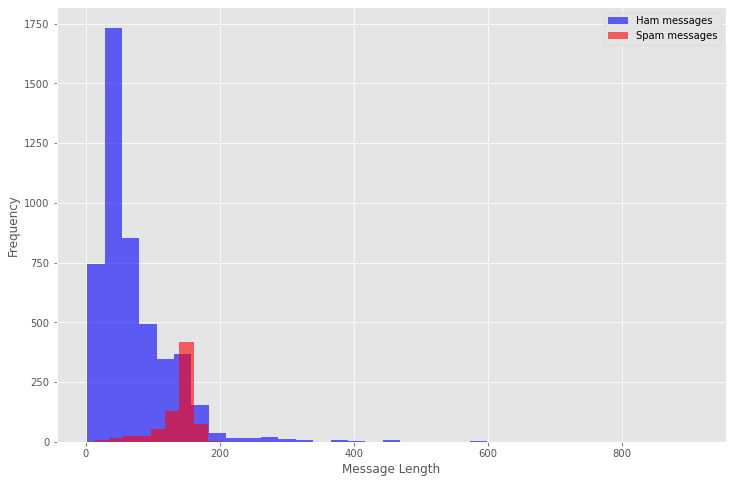

In [69]:
plt.figure(figsize=(12, 8))

data[data.v1==0].message_len.plot(bins=35, kind='hist', color='blue', 
                                       label='Ham messages', alpha=0.6)
data[data.v1==1].message_len.plot(kind='hist', color='red', 
                                       label='Spam messages', alpha=0.6)
plt.legend()
plt.xlabel("Message Length")

# Text Preprocessing.

In [70]:
df=data.iloc[:,:2]
df.head()

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [71]:
def clean_text(text):
 
    text = re.sub('[^a-zA-Z]', ' ', text)  

    text = text.lower()  

    text = text.split(' ')  
    
    text = [w for w in text if not w in set(stopwords.words('english'))] 

    text = ' '.join(text)    
            
    return text



df['v2'] = df['v2'].apply(lambda x : clean_text(x))
df.head()

,v1,v2
0,0,go jurong point crazy available bugis n gre...
1,0,ok lar joking wif u oni
2,1,free entry wkly comp win fa cup final tkts ...
3,0,u dun say early hor u c already say
4,0,nah think goes usf lives around though


## GloVe for Vectorization

Here we will use GloVe pretrained corpus model to represent our words.It is available in 3 varieties :50D ,100D and 200 Dimentional.We will try 50 D here because the Dataset is small.If you have a larger dataset,you can use 100D or 200D.

In [72]:
def create_corpus(df):
    corpus=[]
    for tweet in tqdm(df['v2']):
        words=[word.lower() for word in word_tokenize(tweet) if((word.isalpha()==1) & (word not in stop))]
        corpus.append(words)
    return corpus

corpus=create_corpus(df)

100%|██████████| 5572/5572 [00:01<00:00, 3252.57it/s]


In [73]:
embedding_dict={}
with open('/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.50d.txt','r') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

In [74]:
MAX_LEN=10
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)

tweet_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

In [75]:
word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 7560


In [76]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,50))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec

100%|██████████| 7560/7560 [00:00<00:00, 330150.12it/s]


# Splitting The Data into train and validation set.

In [77]:
X_train,X_val, y_train, y_val = train_test_split(tweet_pad,df.v1, test_size=.2, random_state=2)

In [87]:
print('Shape of train sequences: ',X_train.shape)
print('Shape of train labels: ',y_train.shape)
print("Shape of Validation sequences: ",X_val.shape)
print("Shape of Validation  labels: ",y_val.shape)

Shape of train sequences:  (4457, 10)
Shape of train labels:  (4457,)
Shape of Validation sequences:  (1115, 10)
Shape of Validation  labels:  (1115,)


# Creating Our Model.

In [79]:
model=Sequential()

embedding_layer=Embedding(num_words,50,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)

model.add(embedding_layer)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2,return_sequences=True))
model.add(tf.keras.layers.LSTM(32,return_sequences=True))
model.add(tf.keras.layers.LSTM(16))
model.add(tf.keras.layers.Dense(16, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

In [80]:
optimzer=Adam(learning_rate=1e-4)
model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['acc'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 10, 50)            378050    
_________________________________________________________________
spatial_dropout1d_6 (Spatial (None, 10, 50)            0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 10, 64)            29440     
_________________________________________________________________
lstm_17 (LSTM)               (None, 10, 32)            12416     
_________________________________________________________________
lstm_18 (LSTM)               (None, 16)                3136      
_________________________________________________________________
dense_13 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_14 (Dense)             (None, 1)                

## Fitting The Model.

In [81]:
history=model.fit(X_train,y_train,batch_size=32,epochs=10,validation_data=(X_val,y_val),verbose=1)

Epoch 1/10
140/140 [==============================] - 8s 58ms/step - loss: 0.6299 - acc: 0.7907 - val_loss: 0.5057 - val_acc: 0.8583
Epoch 2/10
140/140 [==============================] - 7s 52ms/step - loss: 0.4270 - acc: 0.8681 - val_loss: 0.3996 - val_acc: 0.8583
Epoch 3/10
140/140 [==============================] - 7s 53ms/step - loss: 0.3346 - acc: 0.8858 - val_loss: 0.2860 - val_acc: 0.9211
Epoch 4/10
140/140 [==============================] - 7s 53ms/step - loss: 0.2638 - acc: 0.9145 - val_loss: 0.2370 - val_acc: 0.9247
Epoch 5/10
140/140 [==============================] - 8s 54ms/step - loss: 0.2255 - acc: 0.9304 - val_loss: 0.2078 - val_acc: 0.9363
Epoch 6/10
140/140 [==============================] - 7s 53ms/step - loss: 0.2087 - acc: 0.9325 - val_loss: 0.1914 - val_acc: 0.9444
Epoch 7/10
140/140 [==============================] - 8s 59ms/step - loss: 0.1893 - acc: 0.9370 - val_loss: 0.1902 - val_acc: 0.9390
Epoch 8/10
140/140 [==============================] - 8s 56ms/step - 

## Creating a Dataframe of Loss And Accuracy.

In [82]:
model_loss = pd.DataFrame(model.history.history)
model_loss.head()

,loss,acc,val_loss,val_acc
0,0.629852,0.790666,0.505684,0.858296
1,0.426973,0.868073,0.399556,0.858296
2,0.334584,0.885798,0.285979,0.921076
3,0.263797,0.914517,0.237045,0.924664
4,0.225487,0.930447,0.207796,0.936323


## Lets visualize the Loss over the Epochs.

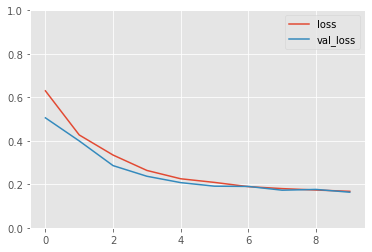

In [84]:
model_loss[['loss','val_loss']].plot(ylim=[0,1])
plt.show()

## Lets visualize the Accuracy over the Epochs.

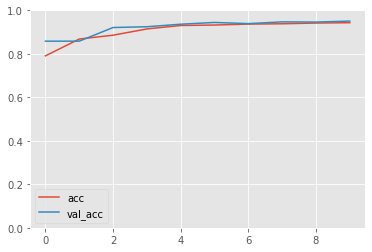

In [86]:
model_loss[['acc','val_acc']].plot(ylim=[0,1])
plt.show()

# Thankyou For Reading!!!